# Solving Single Decisions

## The "Party Problem" example

JMA 11 Jan 2024

In [1]:
# Imports from the python standard library
import math, re, os, sys 
from pathlib import Path
import itertools            # to flatten lists

# Import array and dataframe packages
import numpy as np
# import numpy.linalg as la
import pandas as pd
# import torch

import networkx as nx

# Use to parse xdsl files
# import xml.etree.ElementTree as et
# for extract_net
from ID_operations import * 
import BN


# Import the bokeh python wrappers for javascript plots
#  - a preferred visualization tool
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource, VBar, Span
# from bokeh.io import output_notebook
# output_notebook()

NETWORK_FILE = 'PartyProblem_asym.xdsl' # 'PartyProblem_asym.xdsl'  # 

In [2]:
# BN structure is contained under the node branch
parsed = BN.extract_net(NETWORK_FILE)
nodes, extensions = parsed
# tags tell the node type. 
[( k.get('id'), k.tag) for k in nodes]

found nodes


[('Party_location', 'decision'),
 ('Weather', 'cpt'),
 ('Preferences', 'utility'),
 ('Utility', 'maux'),
 ('Adjustor', 'cpt'),
 ('Detector', 'cpt')]

## Bayes networks object

### Include state and variable names to tensor dimensions

### Add graph structure

It contains 

- the parse of the network as a dictionary with node names as keys
- The graph object showing network structure
- Node Potential objects for computation. 


In [3]:
# CPT contents are stored in row major order (first row, second row, ...)
# Parents are the first matrix dimension -- matrix is Row Markov
pp_net = BN.reap(parsed)
pp_net.pr_nodes()


Edges:  [('Weather', 'Preferences'), ('Party_location', 'Preferences'), ('Weather', 'Detector'), ('Adjustor', 'Detector')] 

>>> Party_location <<<
Party_location: decision
	potential:  ['Party_location']
       [1, 1, 1]

>>> Weather <<<
Weather: cpt
	potential:  ['Weather']
       [0.4000, 0.6000]

>>> Preferences <<<
Preferences: utility
	potential:  ['Preferences', 'Weather', 'Party_location']
       [[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]

>>> Adjustor <<<
Adjustor: cpt
	potential:  ['Adjustor']
       [0.1000, 0.9000]

>>> Detector <<<
Detector: cpt
	potential:  ['Detector', 'Weather', 'Adjustor']
       [[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]



In [4]:
pp_net.pr_influences()



Node	{ancestors}
	{descendants}

Weather :  set() 
	 {'Preferences', 'Detector'} 

Preferences :  {'Weather', 'Party_location'} 
	 set() 

Party_location :  set() 
	 {'Preferences'} 

Detector :  {'Adjustor', 'Weather'} 
	 set() 

Adjustor :  set() 
	 {'Detector'} 



In [5]:
pp_net.pr_named_tensors()
# TODO - The detector should be p(D | W A)  It looks like A is the last dimension, and the marginal. 

Weather 
	 OrderedDict({'Weather': 2})
	tensor([0.4000, 0.6000]) 

Preferences 
	 OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]]) 

Adjustor 
	 OrderedDict({'Adjustor': 2})
	tensor([0.1000, 0.9000]) 

Detector 
	 OrderedDict({'Detector': 2, 'Weather': 2, 'Adjustor': 2})
	tensor([[[0.5100, 0.4900],
         [0.8700, 0.1300]],

        [[0.4800, 0.5200],
         [0.4000, 0.6000]]]) 



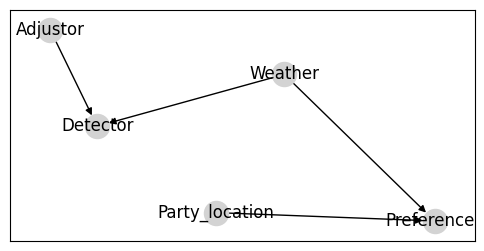

In [6]:
# TODO move to BN class

pp_net.pr_network()

### Extract matrices as tensors.  _List all tensors_

In [7]:
## pretty print one of the variables
pp_net.pr_one_dim_table( 'Weather', tablefmt= '.4f', headers= ['State', 'Value'])



 *** Weather ***
State       Value
--------  -------
Sunshine      0.4
Rain          0.6


### Utilities

In [8]:
# Utility matrix, as a Potential
outcome_potential = pp_net.get_potential('Preferences')
outcome_potential

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[100.,  90.,  40.],
         [  0.,  20.,  50.]]])

In [9]:
u = delta_utility(outcome_potential)
u

OrderedDict({'Preferences': 1, 'Weather': 2, 'Party_location': 3})
	tensor([[[1.0000, 0.9504, 0.5675],
         [0.0000, 0.3229, 0.6667]]])

## Solving the party problem

To determine the optimal policy

* join Detector and Weather CPTs 
* join DW with Utility (Decision is implicit in Utility, w/ unit values for all options)
* marginalize out unobserved Weather (or do this after decn, to get VOI)
* Maximize over options

### First solution - only prior, no observation 

In [10]:
# Note that marginalize_last is symmetric in its arguments. 

preference_transpose = move_named_dim_to_end(pp_net.get_potential("Preferences"),  "Weather")
preference_transpose


OrderedDict({'Preferences': 1, 'Party_location': 3, 'Weather': 2})
	tensor([[[100.,   0.],
         [ 90.,  20.],
         [ 40.,  50.]]])

In [11]:
prior_utility = marginalize_last(preference_transpose, pp_net.get_potential("Weather"))
BN.pr_table(prior_utility, 'Party_location', pp_net.get_node("Party_location").states)
# pp_net.pr_one_dim_table(prior_utility.p, ) 


 *** Party_location ***
--------  --
Outdoors  40
Porch     48
Indoors   46
--------  --


In [12]:
# pre_posterior, shape =  weather_cpt.p @ detector_cpt.p.permute(2,0,1) @ adjustor_cpt.p
# pre_posterior

  # return the joint potential, with the conditioning prob last. 
# join_parent(marginalize_parent(detector_cpt.permute(2,1,0), adjustor_cpt), weather_cpt)
dw_joint = join_parent(pp_net.get_potential("Detector"), pp_net.get_potential('Weather'))
dw_joint


IndexError: pop index out of range

In [ ]:
# P( Weather | Detector) - column markov
# See p 270 Figure 13.6
#   Transpose the joint to get the Detector in last dim, and normalize 
pre_posterior_p = dw_joint.p.sum(-1) 
p = dw_joint.p.transpose(0,1) * (1/pre_posterior_p)
# reverse the shape 
posterior = Potential(p, OrderedDict(list(reversed(dw_joint.shape.items()))) )
print(pre_posterior_p, '\n\n', posterior)



In [ ]:
# One approach is to add a unsqueeze dim to match Detector at the end of preference transpose
# BINGO
extended_preference = preference_transpose.p.unsqueeze(-1).unsqueeze(-1)
print(extended_preference.shape)
# Sum out the weather dimension
policy_values = (extended_preference * posterior.p).sum(2)
print('E[ V | Party_location, Detector] = ')
policy_values
# Next we need to weight the optimal in each column by the pre-posterior.

In [ ]:
extended_preference * posterior.p

In [ ]:
# TODO Need to format list entries before passing to tabulate. 
# TODO looks like the State labels are flipped. 
detector_states= pp_net.n_dict['Detector']['states'].copy()
detector_states.insert(0, 'State')
pr_one_dim_table(policy_values.squeeze(0), 
    'Party_location',
    pp_net.n_dict, 
    floatfmt= ".3f", 
    headers= detector_states)
        

In [ ]:
policy_values.squeeze(0).sum(-1)

In [ ]:
# TODO what is the last dim?  Need to remove it. 
fig, ax = plt.subplots(1,2, figsize = (6, 2.6))
policy_values_2d_a = pd.DataFrame(policy_values.squeeze(0)[:,:,1], columns = pp_net.n_dict['Detector']['states'], 
                                index = pp_net.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_a, annot=True, xticklabels=True, yticklabels=True, ax=ax[0])
policy_values_2d_b = pd.DataFrame(policy_values.squeeze(0)[:,:,0], columns = pp_net.n_dict['Detector']['states'], 
                                index = pp_net.n_dict['Party_location']['states'])
sn.heatmap(policy_values_2d_b, annot=True, xticklabels=True, yticklabels=True, ax=ax[1])

In [ ]:
# Find the max value in each column. 
decn = policy_values.max(1)
decn.values, decn.indices

In [ ]:
# Value with information. 
# However utility should be applied after computing expected values to get certain equivalents
# sigh
# 0.7782 * 0.44 + 0.6557 * 0.56
decn.values @ get_potential('Weather', pp_net.n_dict).p